In [1]:
import pandas as pd
import os

In [2]:
save_dir = r'data\ssusa'
os.makedirs(save_dir, exist_ok=True)

In [3]:
# Define the directory path
data_dir = save_dir

# Define file paths
sequences_path = data_dir + r'\ssusa_finalsequences.csv'
deployments_path = data_dir + r'\ssusa_finaldeployments.csv'

In [4]:
# Load the CSV files
sequences_df = pd.read_csv(
    sequences_path,
    na_values=["NA", " "],
    dtype={
        "Year": "Int64",
        "Sequence_ID": "object",
        "Group_Size": "Int64",
    },
    keep_default_na=True,
    parse_dates=["Start_Time", "End_Time"]
)
print(f"Number of records in sequences_df: {len(sequences_df)}")
deployments_df = pd.read_csv(
    deployments_path,
    na_values=["NA", " "],
    dtype={
        "Year": "Int64",
        "Survey_Nights": "float64", 
        "Latitude": "float64",
        "Longitude": "float64",
    },
    keep_default_na=True,
    parse_dates=["Start_Date", "End_Date"]
)
print(f"Number of records in deployments_df: {len(deployments_df)}")

Number of records in sequences_df: 987979
Number of records in deployments_df: 9679


In [5]:
# Get all common columns
common_cols = set(sequences_df.columns).intersection(deployments_df.columns)
print(common_cols)

{'Camera_Trap_Array', 'Deployment_ID', 'Project', 'Year'}


In [6]:
# Merge on both 'Deployment_ID' and 'Year'
merged_df = pd.merge(
    sequences_df, 
    deployments_df, 
    on=list(common_cols), 
    how='left'
)

merged_df = merged_df.drop_duplicates()

print(f"Number of records in merged_df: {len(merged_df)}")


Number of records in merged_df: 987977


In [7]:
sequences_per_class = sequences_df['Class'].value_counts(dropna=False)
print(sequences_per_class)

Class
Mammalia      901277
Aves           45491
NaN            39557
Insecta          853
Reptilia         767
Arachnida         20
Amphibia          10
Gastropoda         4
Name: count, dtype: int64


In [8]:
# Calculate the number of records for Mammalia and non-Mammalia classes
mammal_count = sequences_df[sequences_df['Class'] == 'Mammalia'].shape[0]
non_mammal_count = sequences_df[sequences_df['Class'] != 'Mammalia'].shape[0]

print(f"Number of Mammalia records: {mammal_count}")
print(f"Number of non-Mammalia records: {non_mammal_count}")

print(f"Percentage of non-Mammalia records: {non_mammal_count/ len(sequences_df) * 100:.2f}%")

Number of Mammalia records: 901277
Number of non-Mammalia records: 86702
Percentage of non-Mammalia records: 8.78%


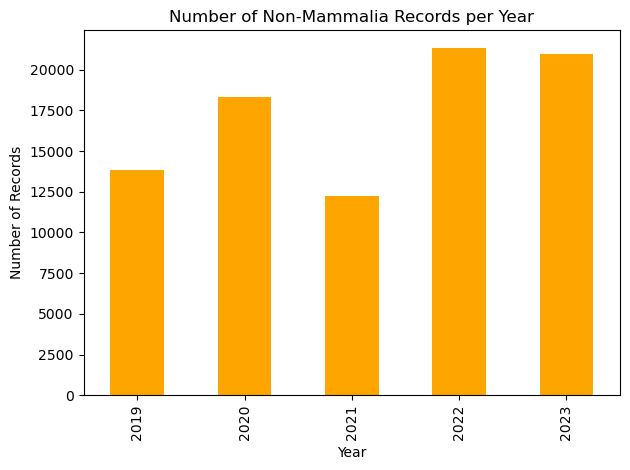

In [9]:
# Count number of non-Mammalia records per year
non_mammal_per_year = sequences_df[sequences_df['Class'] != 'Mammalia'].groupby('Year').size()

# Plot
import matplotlib.pyplot as plt

non_mammal_per_year.plot(kind='bar', color='orange')
plt.title('Number of Non-Mammalia Records per Year')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.tight_layout()
plt.show()

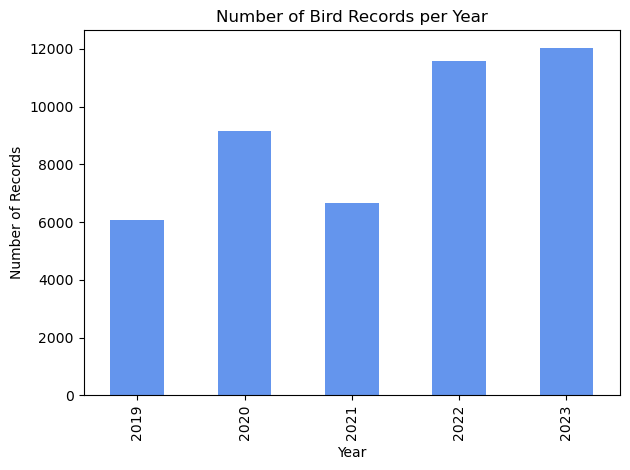

In [10]:
# Count number of bird records per year
bird_per_year = sequences_df[sequences_df['Class'] == 'Aves'].groupby('Year').size()

# Plot
bird_per_year.plot(kind='bar', color='cornflowerblue')
plt.title('Number of Bird Records per Year')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.tight_layout()
plt.show()

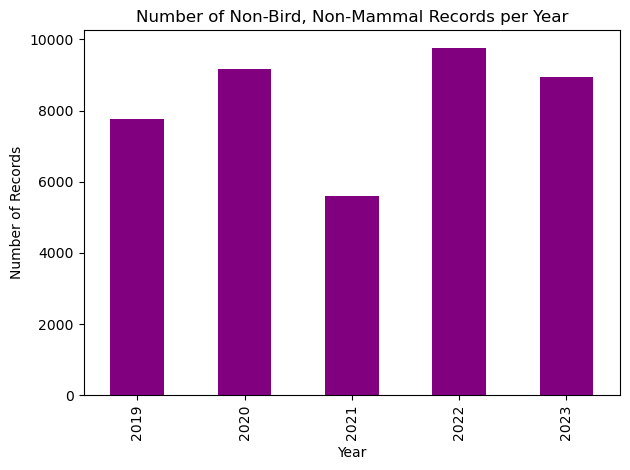

In [11]:
# Filter for non-bird, non-mammal records
non_bird_non_mammal = sequences_df[
    (sequences_df['Class'] != 'Mammalia') & (sequences_df['Class'] != 'Aves')
]

# Count per year
non_bird_non_mammal_per_year = non_bird_non_mammal.groupby('Year').size()

# Plot
non_bird_non_mammal_per_year.plot(kind='bar', color='purple')
plt.title('Number of Non-Bird, Non-Mammal Records per Year')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.tight_layout()
plt.show()

In [12]:
deleted_records = len(sequences_df) - mammal_count
sequences_df = sequences_df[sequences_df['Class'] == 'Mammalia']
merged_df = merged_df[merged_df['Class'] == 'Mammalia']

print(f"Deleted {deleted_records} records.\n Remaining records: {len(sequences_df)}")

Deleted 86702 records.
 Remaining records: 901277


In [13]:
# Columns to convert to Proper Case
prop_case_cols = [
    'Class', 'Order', 'Family', 'Genus', 'Species', 'Habitat', 
    'Development_Level', 'Feature_Type', 'Common_Name', 
    'Site_Name', 'Age', 'Sex'
]

# First, replace blank or whitespace-only strings with NaN for Age, Sex, and Group_Size
merged_df[['Age', 'Sex', 'Group_Size']] = merged_df[['Age', 'Sex', 'Group_Size']].replace(r'^\s*$', pd.NA, regex=True)

# Group_Size: Replace missing with 0 and convert to numeric
merged_df['Group_Size'] = merged_df['Group_Size'].fillna(0)
merged_df['Group_Size'] = pd.to_numeric(merged_df['Group_Size'], errors='coerce').fillna(0).astype(int)

# Age and Sex: Replace missing with 'Unknown'
merged_df['Age'] = merged_df['Age'].fillna('Unknown')
merged_df['Sex'] = merged_df['Sex'].fillna('Unknown')

# Now apply proper case to selected columns
for col in prop_case_cols:
    merged_df[col] = merged_df[col].str.lower()

In [14]:
merged_df.head()

,Year,Project,Camera_Trap_Array,Deployment_ID,Sequence_ID,Start_Time,End_Time,Class,Order,Family,...,Group_Size,Site_Name,Start_Date,End_Date,Survey_Nights,Latitude,Longitude,Habitat,Development_Level,Feature_Type
0,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s1,2019-08-31 06:50:00,2019-08-31 06:50:00,mammalia,carnivora,ursidae,...,1,ak_forest_crupi_21_dep_01,2019-08-31,2019-11-03,64.0,59.42643,-136.2225,forest,wild,water source
1,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s2,2019-08-31 14:15:00,2019-08-31 14:17:00,mammalia,carnivora,ursidae,...,1,ak_forest_crupi_21_dep_01,2019-08-31,2019-11-03,64.0,59.42643,-136.2225,forest,wild,water source
2,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s3,2019-08-31 18:22:00,2019-08-31 18:22:00,mammalia,carnivora,ursidae,...,1,ak_forest_crupi_21_dep_01,2019-08-31,2019-11-03,64.0,59.42643,-136.2225,forest,wild,water source
3,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s4,2019-08-31 20:58:00,2019-08-31 20:58:00,mammalia,carnivora,ursidae,...,1,ak_forest_crupi_21_dep_01,2019-08-31,2019-11-03,64.0,59.42643,-136.2225,forest,wild,water source
4,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s4,2019-08-31 20:58:00,2019-08-31 20:58:00,mammalia,carnivora,ursidae,...,2,ak_forest_crupi_21_dep_01,2019-08-31,2019-11-03,64.0,59.42643,-136.2225,forest,wild,water source


In [15]:
# Check if there are any NaN values in the 'Common_Name' column of merged_df
has_common_name_nas = merged_df['Common_Name'].isna().any()
print(f"Any NaNs in 'Common_Name': {has_common_name_nas}")

Any NaNs in 'Common_Name': False


In [16]:
# Find rows where Species, Order, Family, or Genus is NA
missing_taxa = merged_df[merged_df[['Species', 'Order', 'Family', 'Genus']].isna().any(axis=1)]

# Show a sample of unique common names from these rows
print(missing_taxa['Common_Name'].unique())

['sciuridae family' 'mammal' 'canine family' 'sylvilagus species'
 'leporidae family' 'mephitidae family' 'cervidae family'
 'glaucomys species' 'peromyscus species' 'neotoma species'
 'rattus species' 'mustelidae family' 'ursus species'
 'cetartiodactyla order' 'dipodomys species' 'felidae family' 'bat'
 'canis species' 'carnivora order' 'cricetidae family' 'mephitis species'
 'rodent' 'muridae family' 'myotis species' 'neotamias species'
 'odocoileus species' 'sciurus species' 'sorex species' 'soricidae family'
 'tamias species' 'mustela species' 'bovidae family' 'heteromyidae family'
 'lepus species' 'myodes species' 'tamiasciurus species']


In [17]:
# Count number of missing taxa per Common_Name per Year
missing_taxa_counts = missing_taxa.groupby(['Common_Name']).size().reset_index(name='Number_of_Records')
# Order by Number_of_Records in descending order   
missing_taxa_counts = missing_taxa_counts.sort_values(by='Number_of_Records', ascending=False)
missing_taxa_counts

,Common_Name,Number_of_Records
14,mammal,11424
27,rodent,7252
25,peromyscus species,6367
28,sciuridae family,3425
32,sylvilagus species,2613
12,leporidae family,1246
29,sciurus species,1203
10,glaucomys species,937
24,odocoileus species,698
23,neotoma species,668


In [18]:
missing_taxa_counts_by_year = missing_taxa['Year'].value_counts().sort_index()
print(missing_taxa_counts_by_year)

Year
2019     4354
2020     5263
2021     7034
2022     9114
2023    12074
Name: count, dtype: Int64


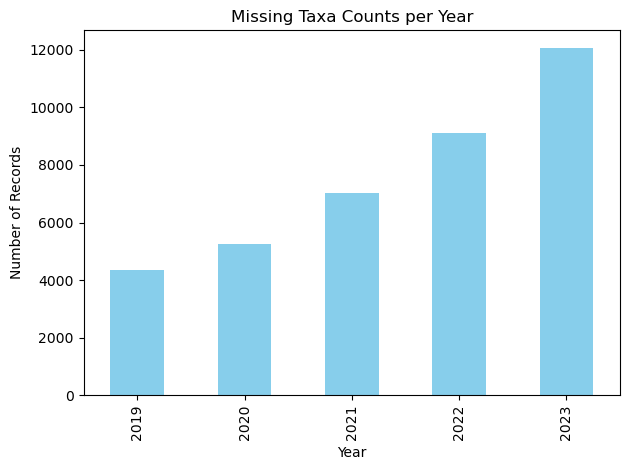

In [19]:
import matplotlib.pyplot as plt

missing_taxa_counts_by_year.plot(kind='bar', color='skyblue')
plt.title('Missing Taxa Counts per Year')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.tight_layout()
plt.show()

In [20]:
# Calculate the proportion of missing_taxa_counts records compared to merged_df
missing_taxa_counts_sum = missing_taxa_counts['Number_of_Records'].sum()
proportion_missing_taxa_counts = missing_taxa_counts_sum / len(merged_df)
print(f"Number of missing taxa: {missing_taxa_counts_sum}")
print(f"Proportion of missing_taxa_counts compared to merged_df: {proportion_missing_taxa_counts * 100:.2f}%")

# Count records where Genus is 'homo' and Species is 'sapiens' in merged_df
homo_sapiens_count = merged_df[(merged_df['Genus'] == 'homo') & (merged_df['Species'] == 'sapiens')].shape[0]
print(f"Number of records with Genus='homo' and Species='sapiens': {homo_sapiens_count}")
proportion_human = homo_sapiens_count / len(merged_df)
print(f"Proportion of Human data compared to merged_df: {proportion_human * 100 :.2f}%")

Number of missing taxa: 37839
Proportion of missing_taxa_counts compared to merged_df: 4.20%
Number of records with Genus='homo' and Species='sapiens': 84889
Proportion of Human data compared to merged_df: 9.42%
